In [72]:
import pandas as pd
import numpy as np
import arviz as az
import graphviz as gz
import matplotlib.pyplot as plt
import pymc as pm
import seaborn as sns
from scipy.special import expit as logistic
from patsy import dmatrix

sns.set()
az.style.use("arviz-darkgrid")

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

In [73]:
data_path = 'data/processed_data.csv'

In [74]:
data = pd.read_csv(data_path)

/var/folders/5l/01f91zmj7mq1k2wrl_k7z2740000gn/T/ipykernel_71912/560202589.py:1: DtypeWarning: Columns (579,629,630,631,664,665,666,667,668,669,670,684,685,686,687,688,714) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_path)


In [75]:
data.head()

,Unnamed: 0,CCAA,TMUNI,IDENTHOGAR,NORDEN,SEXO,EDAD,INFOR_DISC,INFOR_HOG,INFOR_RELAC,...,B_15_3,B_15_4,B_15_5,B_15_6,B_15_7,B_15_8,B_15_9,B_15_10,B_16,FACTOR
0,1,16,4,7,1,1,56,1,,,...,,,,,,,,,,222.916
1,2,16,4,10,2,1,67,1,,,...,,,,,,,,,,296.805
2,3,16,5,21,1,2,52,1,,,...,,,,,,,,,,300.734
3,4,16,5,24,3,1,37,6,1,3,...,,,,,,,,,,326.648
4,5,16,5,30,4,1,56,1,,,...,,,,,,,,,,324.750


In [76]:
relevant_columns = ['SEXO', 'EDAD', 'H_14']

In [77]:
data = data[relevant_columns]

In [78]:
data = data.rename(columns={'SEXO': 'sex', 'EDAD': 'age', 'H_14': 'discrimination'})

In [79]:
data['sex'] -= 1

In [80]:
data.head()

,sex,age,discrimination
0,0,56,1
1,0,67,1
2,1,52,1
3,0,37,1
4,0,56,2


In [81]:
data.discrimination.unique()

array([1, 2, 9, 3, 4])

In [82]:
data.sex.unique()

array([0, 1])

In [83]:
data.age.sort_values().unique()

array([  6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,
        19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,
        32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,
        45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
        58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 104, 106])

In [84]:
data = data.query('discrimination != 9')

In [85]:
data = data.sample(2000)

In [86]:
data.groupby('sex').discrimination.mean()

sex
0    1.134734
1    1.102435
Name: discrimination, dtype: float64

### Linear Regression, Gaussian Likelihood

In [16]:
with pm.Model() as model:
    
    # Uninformative Priors
    alpha = pm.Normal('alpha', mu=0, sigma=0.5, shape=2)
    beta = pm.Normal('beta', mu=0, sigma=0.5, shape=2)
    sigma = pm.HalfNormal('sigma', sigma=0.5)

    # IDs
    sex_id = pm.intX(pm.ConstantData('sex_id', data['sex']))

    # Expected value of outcome
    mu = alpha[sex_id] + beta[sex_id]*(data['age']/data.age.max())
    # Likelihood
    discrimination = pm.Normal('discrimination', mu=mu, sigma=sigma, observed=(data['discrimination']-1))

In [17]:
pm.model_to_graphviz(model)

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [17]:
with model:
    prior = pm.sample_prior_predictive(samples=1000, random_seed=rng)

Sampling: [alpha, beta, discrimination, sigma]


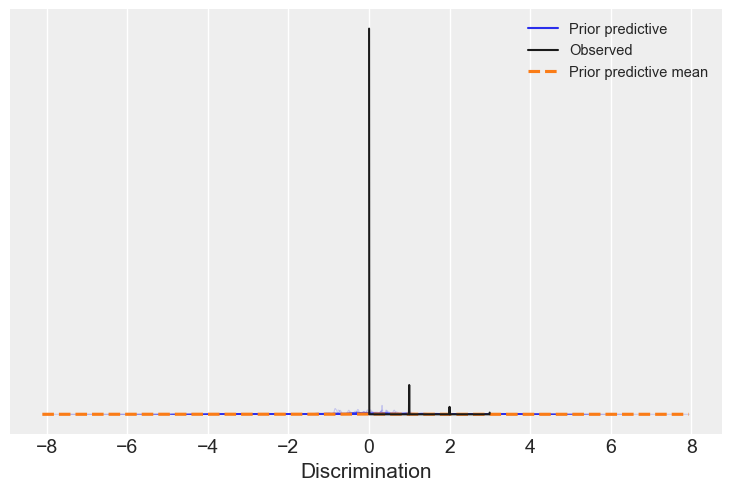

In [18]:
az.plot_ppc(prior, group='prior')
plt.xlabel('Discrimination')
plt.show()

In [19]:
with model:
    # draw 1000 posterior samples
    idata = pm.sample(random_seed=rng)
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [discrimination]


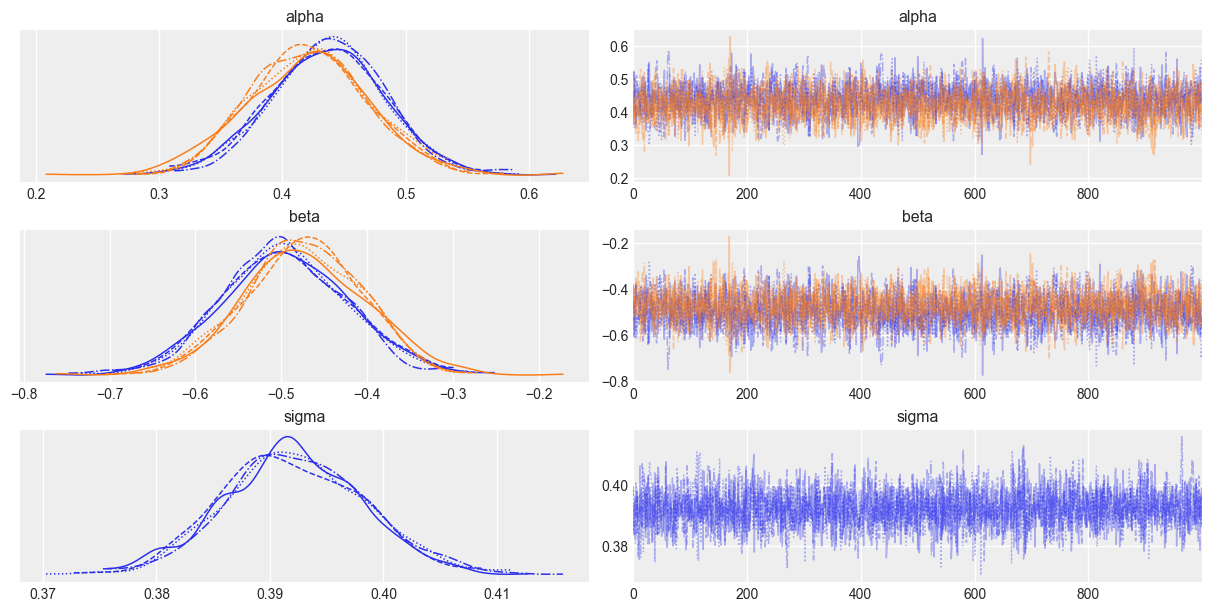

In [20]:
az.plot_trace(idata);

In [21]:
az.summary(idata, round_to=2)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.44,0.05,0.35,0.52,0.0,0.0,1945.22,1801.02,1.0
alpha[1],0.42,0.05,0.34,0.52,0.0,0.0,2227.74,2192.46,1.0
beta[0],-0.50,0.07,-0.62,-0.35,0.0,0.0,1930.71,1801.05,1.0
beta[1],-0.47,0.07,-0.61,-0.36,0.0,0.0,2246.41,2174.35,1.0
sigma,0.39,0.01,0.38,0.40,0.0,0.0,3412.08,2259.46,1.0


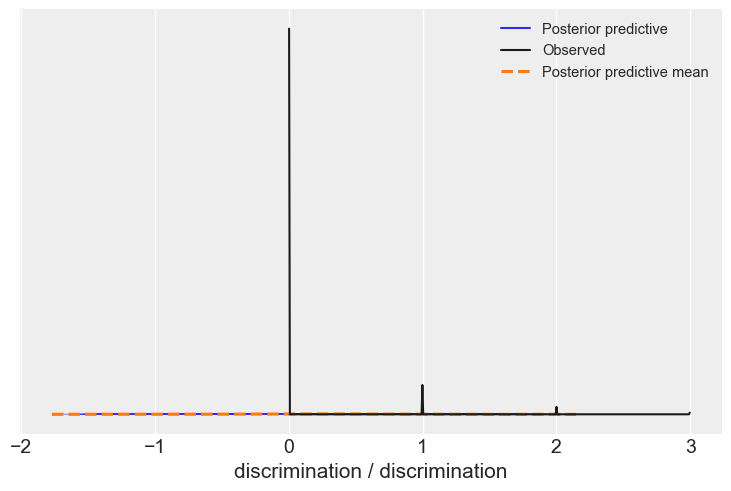

In [22]:
az.plot_ppc(idata, num_pp_samples=500)
plt.show()

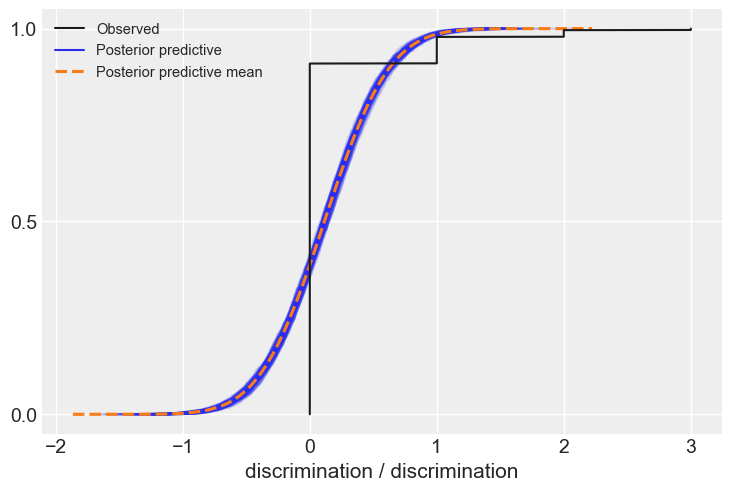

In [23]:
az.plot_ppc(idata, num_pp_samples=100, kind='cumulative')
plt.show()

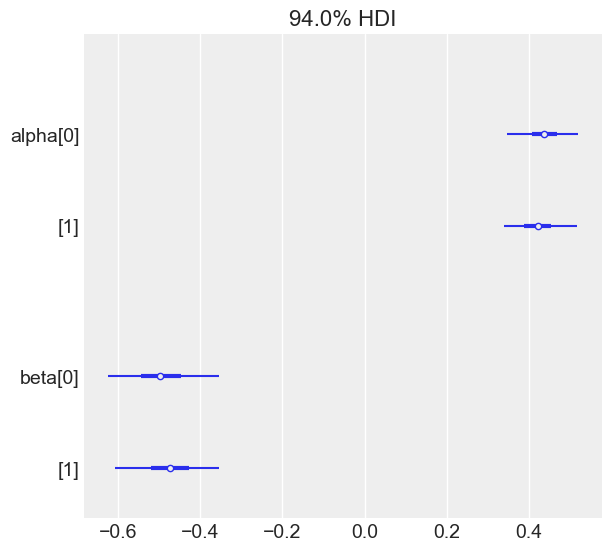

In [24]:
az.plot_forest(idata, var_names=['alpha', 'beta'], combined=True)
plt.show()

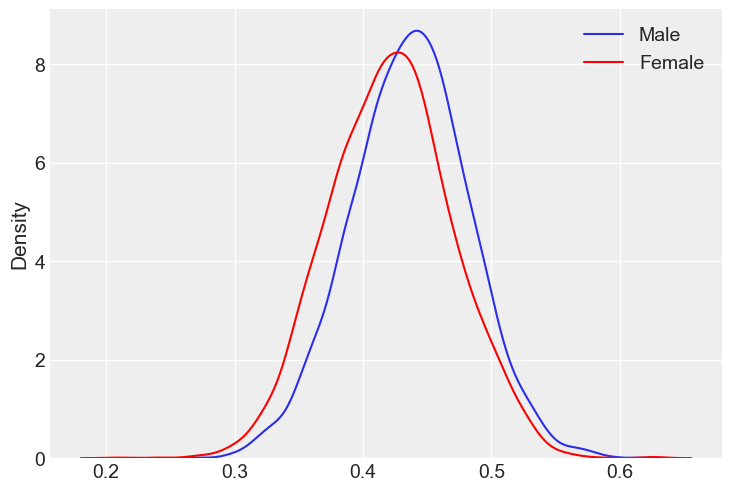

In [25]:
sns.kdeplot(np.concatenate(idata.posterior['alpha'][:, :, 0]), label='Male')
sns.kdeplot(np.concatenate(idata.posterior['alpha'][:, :, 1]), label='Female', color='red')
plt.legend()
plt.show()

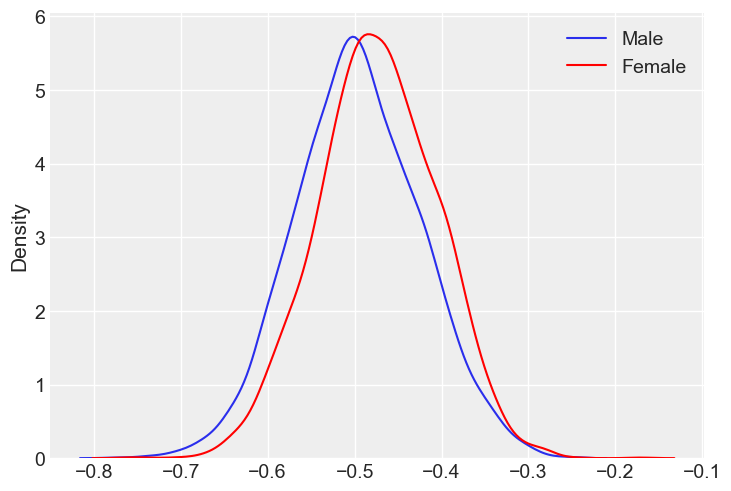

In [26]:
sns.kdeplot(np.concatenate(idata.posterior['beta'][:, :, 0]), label='Male')
sns.kdeplot(np.concatenate(idata.posterior['beta'][:, :, 1]), label='Female', color='red')
plt.legend()
plt.show()

In [27]:
male_alpha = np.concatenate(idata.posterior['alpha'][:, :, 0])
male_beta = np.concatenate(idata.posterior['beta'][:, :, 0])

female_alpha = np.concatenate(idata.posterior['alpha'][:, :, 1])
female_beta = np.concatenate(idata.posterior['beta'][:, :, 1])

In [28]:
male_alpha.mean(), female_alpha.mean()

(0.436604046139136, 0.4214442561811238)

In [29]:
age_range = np.arange(data.age.min(), data.age.max()+1, 1)/data.age.max()

In [30]:
disc_male = (male_alpha + age_range[:, None]*male_beta).T
disc_female = (female_alpha + age_range[:, None]*female_beta).T

/Users/ipeletier/Personal/articles/.venv/lib/python3.9/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/ipeletier/Personal/articles/.venv/lib/python3.9/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


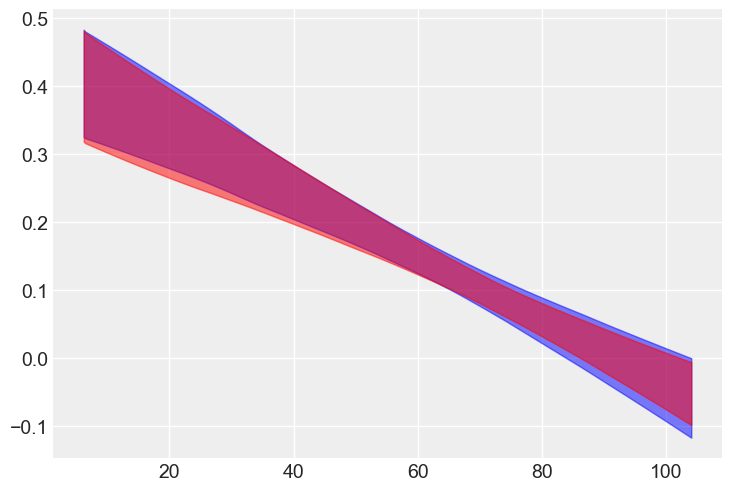

In [31]:
az.plot_hdi(age_range*data.age.max(), disc_male, color='blue')
az.plot_hdi(age_range*data.age.max(), disc_female, color='red')
plt.show()

/Users/ipeletier/Personal/articles/.venv/lib/python3.9/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/ipeletier/Personal/articles/.venv/lib/python3.9/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


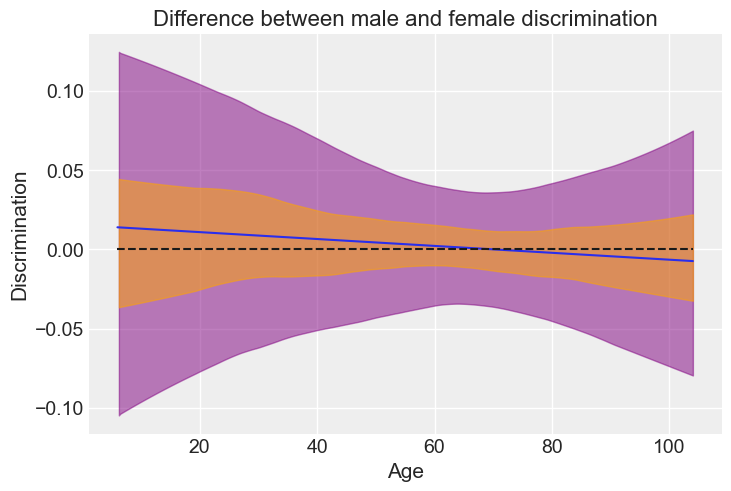

In [32]:
az.plot_hdi(age_range*data.age.max(), disc_male - disc_female, color='purple', hdi_prob=0.95)
az.plot_hdi(age_range*data.age.max(), disc_male - disc_female, color='orange', hdi_prob=0.50)
plt.plot(age_range*data.age.max(),(disc_male - disc_female).mean(axis=0))
plt.title('Difference between male and female discrimination')
plt.ylabel('Discrimination')
plt.xlabel('Age')
plt.hlines(xmin=data.age.min(), xmax=data.age.max(), y=0, color='k', linestyles='--')
plt.show()

### Spline

In [115]:
data.sort_values(by='age', inplace=True)

In [116]:
data.age.max()

101

In [117]:
num_knots = 6
knot_list = np.linspace(0, 110, num_knots+2)[1:-1]

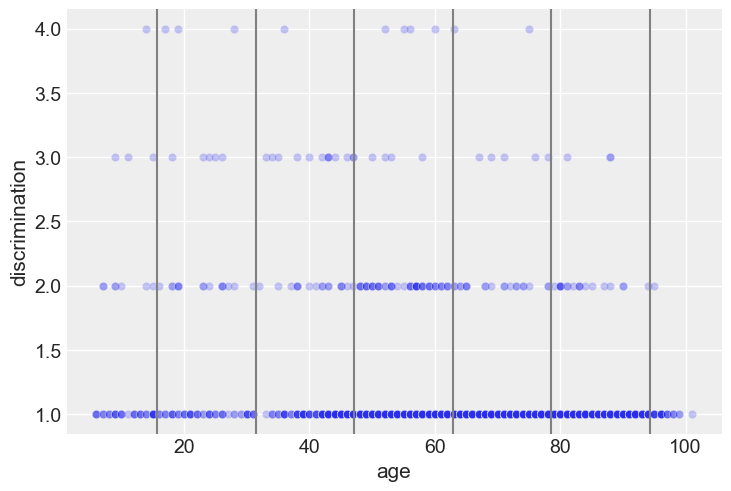

In [118]:
sns.scatterplot(data=data, x='age', y='discrimination', alpha=0.25)
for knot in knot_list:
    plt.gca().axvline(knot, color="grey");
plt.show()

In [119]:
B = dmatrix(
    'bs(age, knots=knots, degree=3, include_intercept=True) - 1',
    {'age': data.age.values, 'knots': knot_list[-1:1]},
)

In [120]:
B

DesignMatrix with shape (2000, 4)
  Columns:
    ['bs(age, knots=knots, degree=3, include_intercept=True)[0]',
     'bs(age, knots=knots, degree=3, include_intercept=True)[1]',
     'bs(age, knots=knots, degree=3, include_intercept=True)[2]',
     'bs(age, knots=knots, degree=3, include_intercept=True)[3]']
  Terms:
    'bs(age, knots=knots, degree=3, include_intercept=True)' (columns 0:4)
  (to view full data, use np.asarray(this_obj))

In [121]:
with pm.Model() as splines:
    tau = pm.HalfCauchy("tau", 1) 
    beta = pm.Normal("beta", mu=0, sigma=tau, shape=B.shape[1])
    mu = pm.Deterministic("mu", pm.math.dot(B, beta))
    sigma = pm.HalfNormal("sigma", 1)
    disc = pm.Normal("disc", mu, sigma, observed=data.discrimination.values)
    idata_s = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


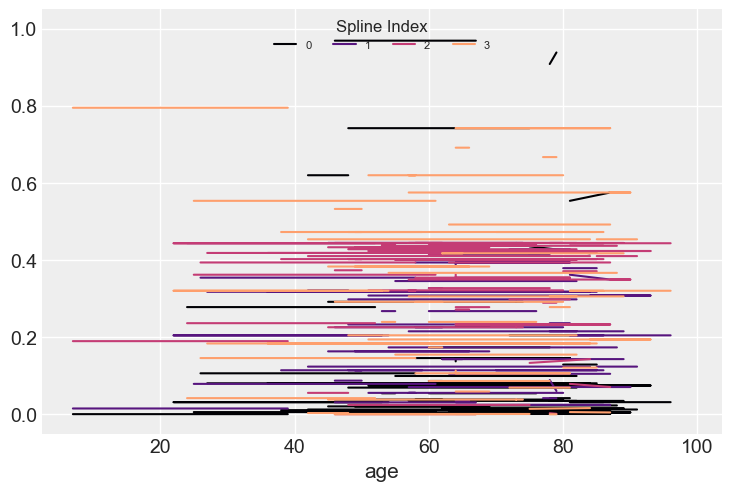

In [122]:
spline_df = (
    pd.DataFrame(B)
    .assign(age=data.age)
    .melt("age", var_name="spline_i", value_name="value")
)

color = plt.cm.magma(np.linspace(0, 0.8, spline_df.spline_i.nunique()))

fig = plt.figure()
for i, c in enumerate(color):
    subset = spline_df.query(f"spline_i == {i}")
    subset.plot("age", "value", c=c, ax=plt.gca(), label=i)
plt.legend(title="Spline Index", loc="upper center", fontsize=8, ncol=7)
plt.show()

In [388]:
COORDS

{'splines': array([0, 1, 2, 3, 4, 5, 6])}

In [357]:
COORDS = {"splines": np.arange(B.shape[1])}
with pm.Model(coords=COORDS) as spline_model:
    a = pm.Normal("a", 100, 5)
    w = pm.Normal("w", mu=0, sigma=3, size=B.shape[1], dims="splines")
    mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(B, order="F"), w.T))
    sigma = pm.Exponential("sigma", 1)
    D = pm.Normal("D", mu=mu, sigma=sigma, observed=data.discrimination)

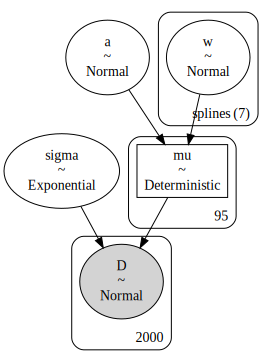

In [358]:
pm.model_to_graphviz(spline_model)

In [359]:
with spline_model:
    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample(draws=1000, tune=1000, random_seed=RANDOM_SEED, chains=4))
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sampling: [D, a, sigma, w]


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (2000,) and arg 1 with shape (95,).
Apply node that caused the error: normal_rv{0, (0, 0), floatX, True}(RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7FE960A95D60>), [2000], 11, mu, sigma)
Toposort index: 7
Inputs types: [RandomGeneratorType, TensorType(int64, shape=(1,)), TensorType(int64, shape=()), TensorType(float64, shape=(95,)), TensorType(float64, shape=())]
Inputs shapes: ['No shapes', (1,), (), (95,), ()]
Inputs strides: ['No strides', (8,), (), (8,), ()]
Inputs values: [Generator(PCG64) at 0x7FE960A95D60, array([2000]), array(11), 'not shown', array(1.18664831)]
Outputs clients: [['output'], ['output']]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

### Spline: WIP

In [446]:
# data_ = data.groupby('age', as_index=False).discrimination.mean()
data_ = data

In [447]:
num_knots = 5

knot_list = np.quantile(data_.age.unique(), np.linspace(0, 1, num_knots), method='nearest')
knot_list

array([  6,  31,  54,  77, 106])

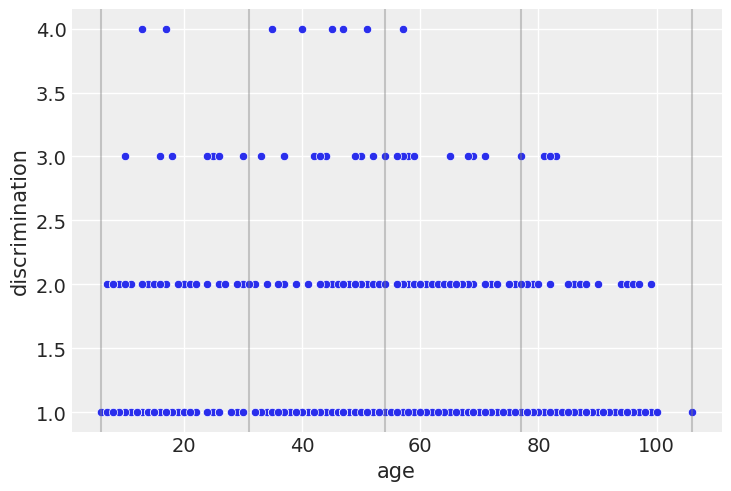

In [448]:
sns.scatterplot(data=data_, x='age', y='discrimination')
for knot in knot_list:
    plt.gca().axvline(knot, color="grey", alpha=0.4);
plt.show()

In [111]:
B = dmatrix(
    'bs(age, knots=knots, degree=3, include_intercept=True) - 1',
    {'age': data_.age.sort_values(), 'knots': knot_list[1:-1]},
)

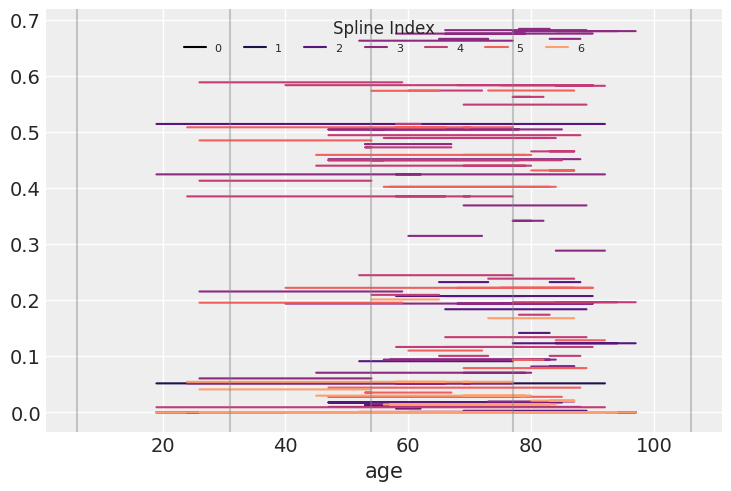

In [450]:
spline_df = (
    pd.DataFrame(B)
    .assign(age=data_.age.sort_values())
    .melt("age", var_name="spline_i", value_name="value")
)

color = plt.cm.magma(np.linspace(0, 0.8, spline_df.spline_i.nunique()))

fig = plt.figure()
for i, c in enumerate(color):
    subset = spline_df.query(f"spline_i == {i}")
    subset.plot("age", "value", c=c, ax=plt.gca(), label=i)
plt.legend(title="Spline Index", loc="upper center", fontsize=8, ncol=7)
for knot in knot_list:
    plt.gca().axvline(knot, color="grey", alpha=0.4);
plt.show()

In [451]:
COORDS = {"splines": np.arange(B.shape[1])}
with pm.Model(coords=COORDS) as spline_model:
    a = pm.Normal("a", 0, 5)
    w = pm.Normal("w", mu=0, sigma=3, size=B.shape[1], dims="splines")
    mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(B, order="F"), w.T))
    sigma = pm.Exponential("sigma", 1)
    D = pm.Normal("D", mu=mu, sigma=sigma, observed=data_.discrimination)

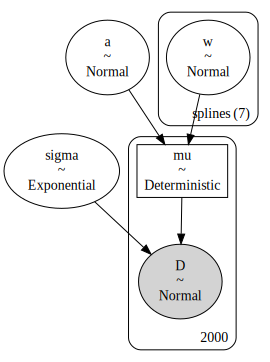

In [452]:
pm.model_to_graphviz(spline_model)

In [453]:
with spline_model:
    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample(draws=1000, tune=1000, random_seed=RANDOM_SEED, chains=4))
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sampling: [D, a, sigma, w]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, w, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1386 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [D]


In [455]:
az.summary(idata, var_names=["a", "w", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.099,1.190,-0.927,3.336,0.059,0.045,400.0,349.0,1.01
w[0],-0.071,1.193,-2.266,2.024,0.059,0.042,402.0,388.0,1.01
w[1],0.280,1.195,-1.944,2.362,0.059,0.042,403.0,345.0,1.01
w[2],-0.115,1.193,-2.321,1.928,0.059,0.045,402.0,349.0,1.01
w[3],0.073,1.191,-2.217,2.069,0.059,0.042,400.0,339.0,1.01
w[4],-0.026,1.191,-2.252,2.037,0.059,0.042,402.0,353.0,1.01
w[5],0.033,1.194,-2.236,2.063,0.059,0.042,401.0,386.0,1.01
w[6],-0.119,1.204,-2.342,2.011,0.059,0.042,411.0,374.0,1.01
sigma,0.399,0.006,0.387,0.411,0.000,0.000,1127.0,1211.0,1.01


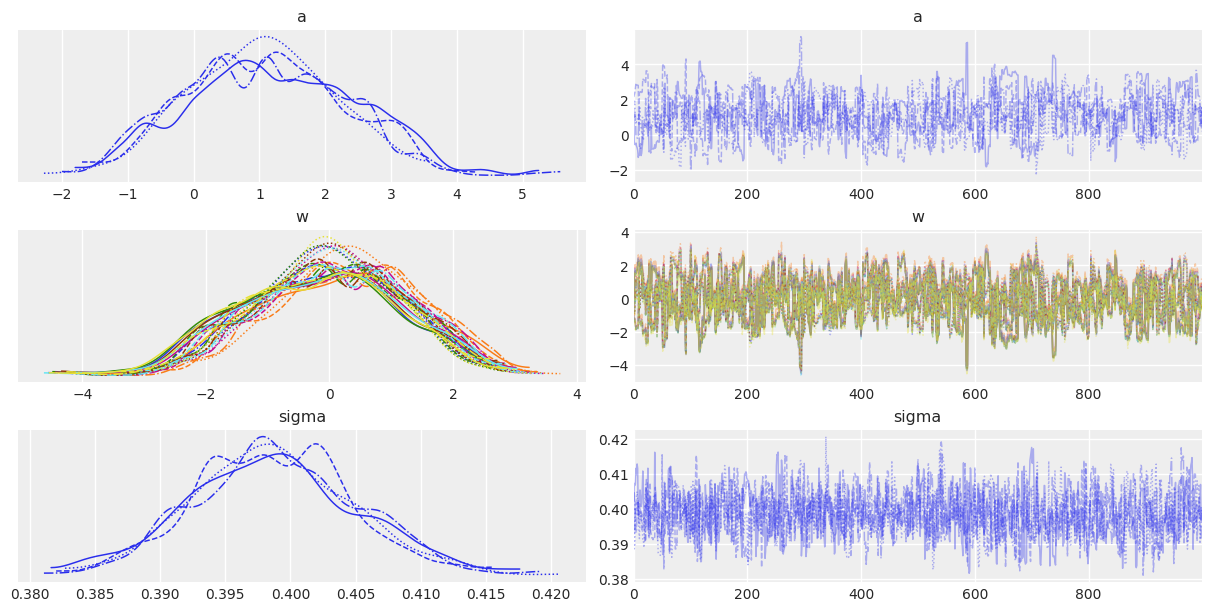

In [456]:
az.plot_trace(idata, var_names=["a", "w", "sigma"]);

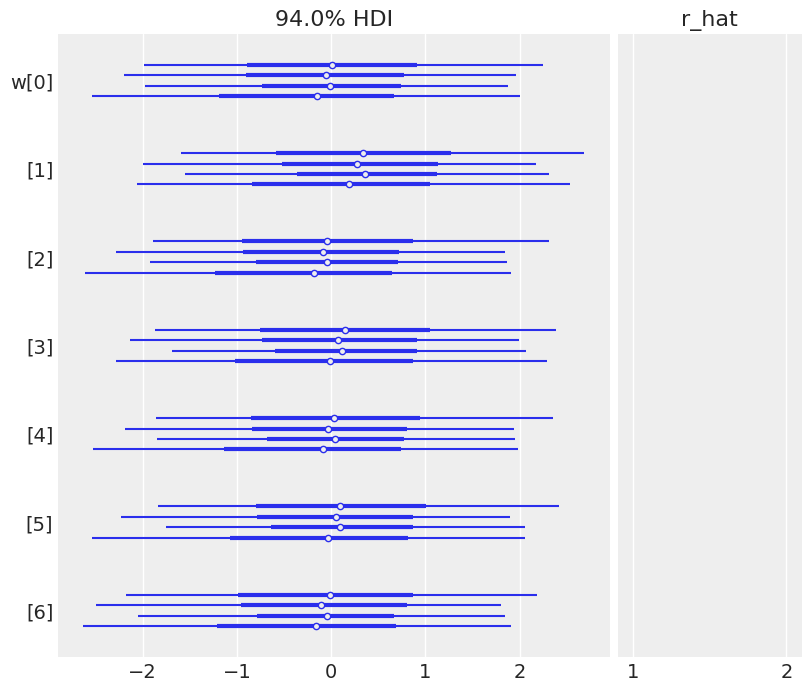

In [457]:
az.plot_forest(idata, var_names=["w"], combined=False, r_hat=True);

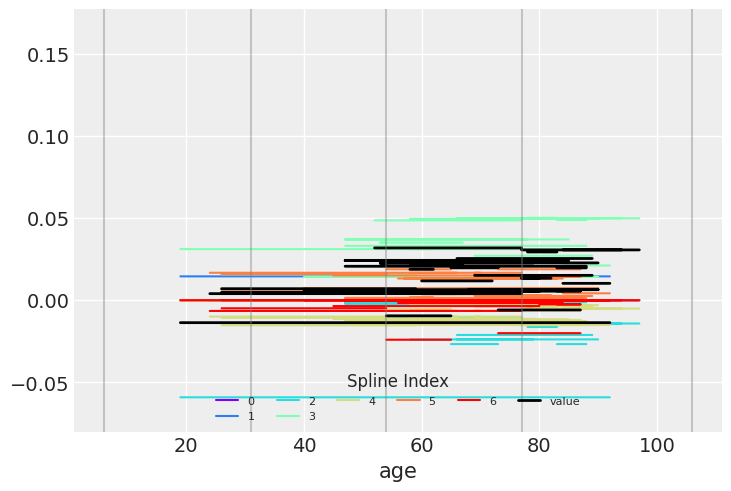

In [458]:
wp = idata.posterior["w"].mean(("chain", "draw")).values

spline_df = (
    pd.DataFrame(B * wp.T)
    .assign(age=data_.age.sort_values())
    .melt("age", var_name="spline_i", value_name="value")
)

spline_df_merged = (
    pd.DataFrame(np.dot(B, wp.T))
    .assign(age=data_.age.sort_values())
    .melt("age", var_name="spline_i", value_name="value")
)


color = plt.cm.rainbow(np.linspace(0, 1, len(spline_df.spline_i.unique())))
fig = plt.figure()
for i, c in enumerate(color):
    subset = spline_df.query(f"spline_i == {i}")
    subset.plot("age", "value", c=c, ax=plt.gca(), label=i)
spline_df_merged.plot("age", "value", c="black", lw=2, ax=plt.gca())
plt.legend(title="Spline Index", loc="lower center", fontsize=8, ncol=6)

for knot in knot_list:
    plt.gca().axvline(knot, color="grey", alpha=0.4);

In [459]:
post_pred = az.summary(idata, var_names=["mu"]).reset_index(drop=True)
data_post = data_.copy().reset_index(drop=True)
data_post["pred_mean"] = post_pred["mean"]
data_post["pred_hdi_lower"] = post_pred["hdi_3%"]
data_post["pred_hdi_upper"] = post_pred["hdi_97%"]

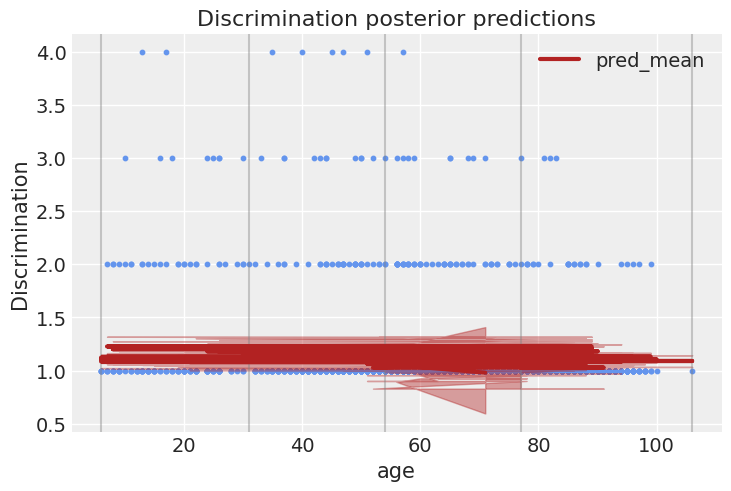

In [461]:
data.plot.scatter(
    "age",
    "discrimination",
    color="cornflowerblue",
    s=10,
    title="Discrimination posterior predictions",
    ylabel="Discrimination",
)
for knot in knot_list:
    plt.gca().axvline(knot, color="grey", alpha=0.4)

data_post.plot("age", "pred_mean", ax=plt.gca(), lw=3, color="firebrick")
plt.fill_between(
    data_post.age,
    data_post.pred_hdi_lower,
    data_post.pred_hdi_upper,
    color="firebrick",
    alpha=0.4,
);

TODO

1. Gaussian Process for Age
2. Ordered logistic, linear model
3. Ordered logistic, gaussian process
4. Ordered logistic, gaussian process, missing values?
5. Ordered logistic, gaussian process, full bayes with coufounder

### Spline: Averaged

In [96]:
data_ = data.groupby('age', as_index=False).discrimination.mean()

In [97]:
num_knots = 5

knot_list = np.quantile(data_.age.unique(), np.linspace(0, 1, num_knots), method='nearest')
knot_list

array([  6,  30,  53,  76, 101])

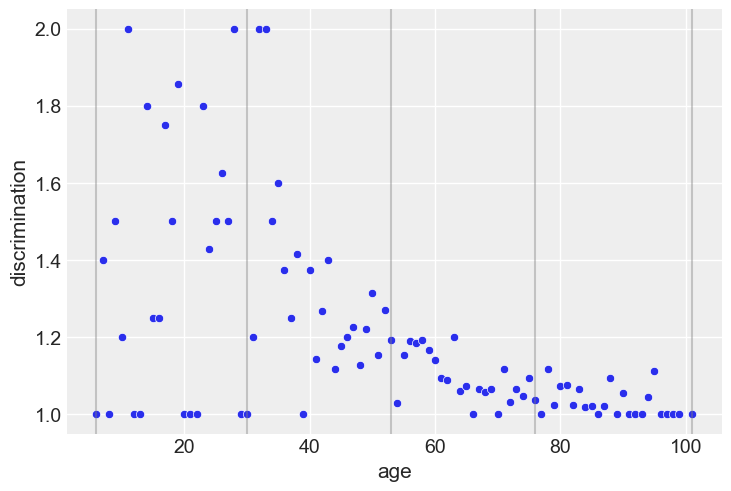

In [98]:
sns.scatterplot(data=data_, x='age', y='discrimination')
for knot in knot_list:
    plt.gca().axvline(knot, color="grey", alpha=0.4);
plt.show()

In [123]:
B = dmatrix(
    'bs(age, knots=knots, degree=3, include_intercept=True) - 1',
    {'age': data_.age.sort_values(), 'knots': knot_list[1:-1]},
)

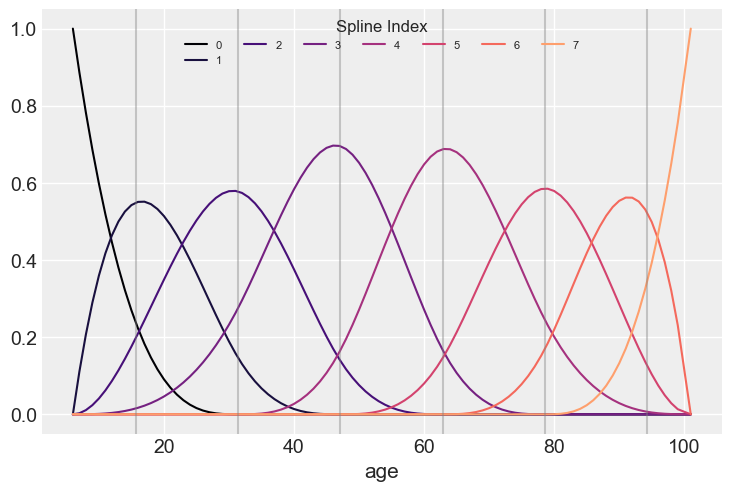

In [124]:
spline_df = (
    pd.DataFrame(B)
    .assign(age=data_.age.sort_values())
    .melt("age", var_name="spline_i", value_name="value")
)

color = plt.cm.magma(np.linspace(0, 0.8, spline_df.spline_i.nunique()))

fig = plt.figure()
for i, c in enumerate(color):
    subset = spline_df.query(f"spline_i == {i}")
    subset.plot("age", "value", c=c, ax=plt.gca(), label=i)
plt.legend(title="Spline Index", loc="upper center", fontsize=8, ncol=7)
for knot in knot_list:
    plt.gca().axvline(knot, color="grey", alpha=0.4);
plt.show()

In [102]:
COORDS = {"splines": np.arange(B.shape[1])}
with pm.Model(coords=COORDS) as spline_model:
    a = pm.Normal("a", 0, 5)
    w = pm.Normal("w", mu=0, sigma=3, size=B.shape[1], dims="splines")
    mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(B, order="F"), w.T))
    sigma = pm.Exponential("sigma", 1)
    D = pm.Normal("D", mu=mu, sigma=sigma, observed=data_.discrimination)

In [103]:
pm.model_to_graphviz(spline_model)

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [104]:
with spline_model:
    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample(draws=1000, tune=1000, random_seed=RANDOM_SEED, chains=4))
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sampling: [D, a, sigma, w]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, w, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
Sampling: [D]


In [105]:
az.summary(idata, var_names=["a", "w", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.076,1.085,-1.014,2.993,0.050,0.036,466.0,616.0,1.01
w[0],0.121,1.092,-1.809,2.171,0.051,0.037,470.0,651.0,1.01
w[1],0.362,1.097,-1.699,2.317,0.050,0.037,477.0,694.0,1.01
w[2],0.493,1.093,-1.468,2.580,0.051,0.039,469.0,637.0,1.01
w[3],0.005,1.094,-1.893,2.128,0.050,0.036,472.0,666.0,1.01
w[4],-0.006,1.090,-1.968,2.083,0.050,0.036,472.0,639.0,1.01
w[5],-0.059,1.098,-2.017,2.014,0.051,0.036,472.0,660.0,1.01
w[6],-0.069,1.087,-2.014,2.023,0.050,0.035,474.0,623.0,1.01
sigma,0.216,0.017,0.185,0.248,0.001,0.000,1122.0,1287.0,1.00


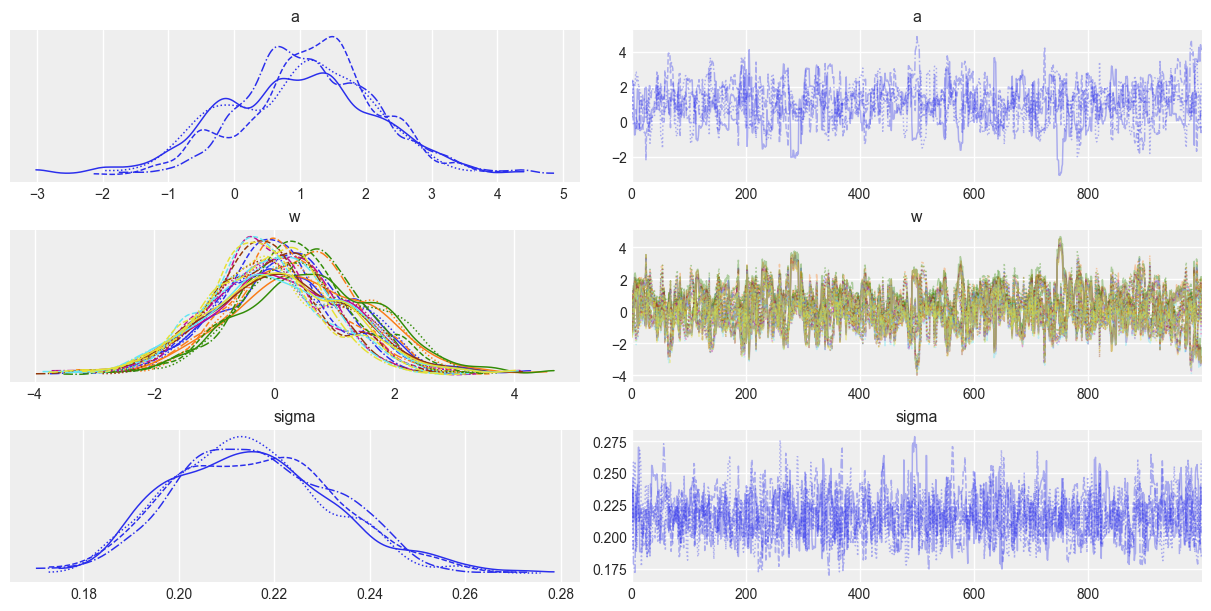

In [106]:
az.plot_trace(idata, var_names=["a", "w", "sigma"]);

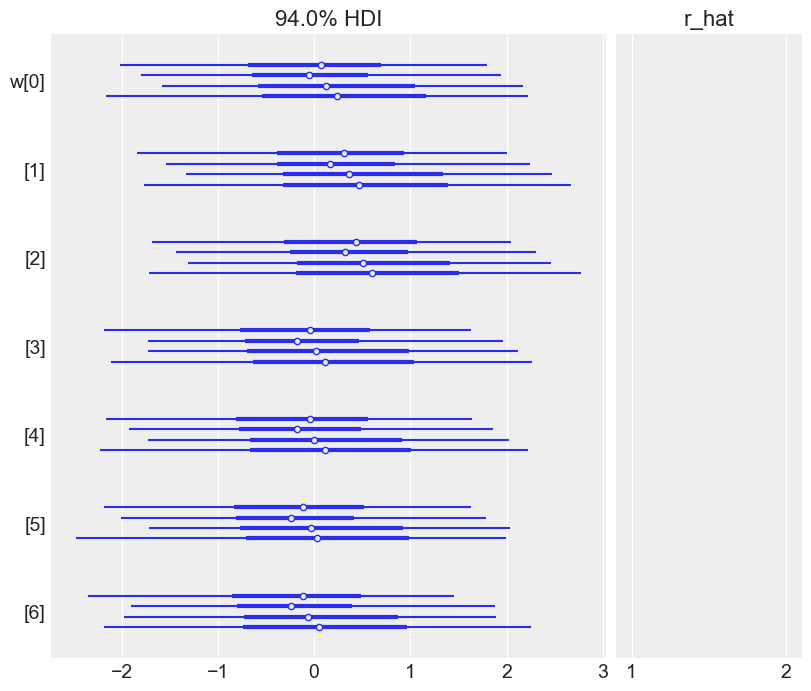

In [107]:
az.plot_forest(idata, var_names=["w"], combined=False, r_hat=True);

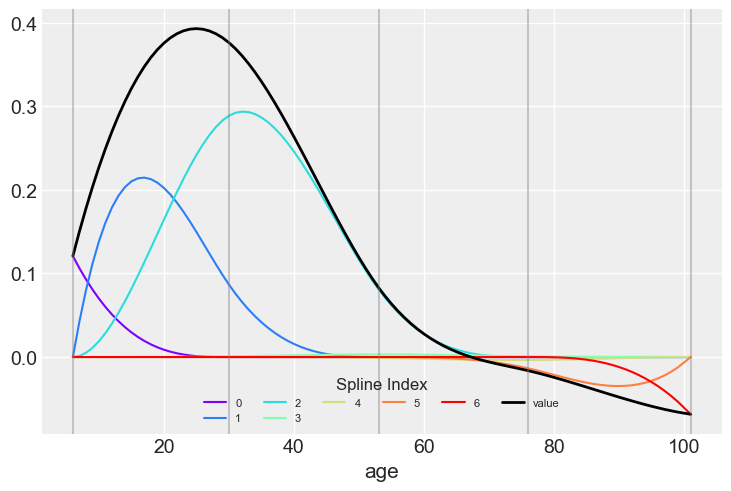

In [108]:
wp = idata.posterior["w"].mean(("chain", "draw")).values

spline_df = (
    pd.DataFrame(B * wp.T)
    .assign(age=data_.age.sort_values())
    .melt("age", var_name="spline_i", value_name="value")
)

spline_df_merged = (
    pd.DataFrame(np.dot(B, wp.T))
    .assign(age=data_.age.sort_values())
    .melt("age", var_name="spline_i", value_name="value")
)


color = plt.cm.rainbow(np.linspace(0, 1, len(spline_df.spline_i.unique())))
fig = plt.figure()
for i, c in enumerate(color):
    subset = spline_df.query(f"spline_i == {i}")
    subset.plot("age", "value", c=c, ax=plt.gca(), label=i)
spline_df_merged.plot("age", "value", c="black", lw=2, ax=plt.gca())
plt.legend(title="Spline Index", loc="lower center", fontsize=8, ncol=6)

for knot in knot_list:
    plt.gca().axvline(knot, color="grey", alpha=0.4);

In [109]:
post_pred = az.summary(idata, var_names=["mu"]).reset_index(drop=True)
data_post = data_.copy().reset_index(drop=True)
data_post["pred_mean"] = post_pred["mean"]
data_post["pred_hdi_lower"] = post_pred["hdi_3%"]
data_post["pred_hdi_upper"] = post_pred["hdi_97%"]

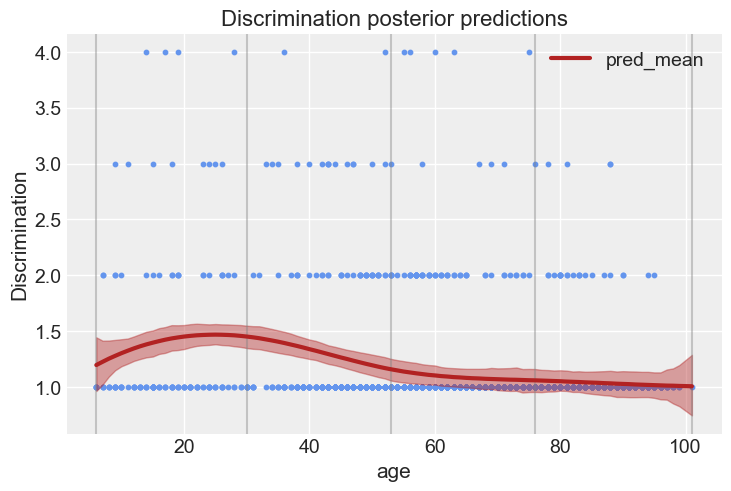

In [110]:
data.plot.scatter(
    "age",
    "discrimination",
    color="cornflowerblue",
    s=10,
    title="Discrimination posterior predictions",
    ylabel="Discrimination",
)
for knot in knot_list:
    plt.gca().axvline(knot, color="grey", alpha=0.4)

data_post.plot("age", "pred_mean", ax=plt.gca(), lw=3, color="firebrick")
plt.fill_between(
    data_post.age,
    data_post.pred_hdi_lower,
    data_post.pred_hdi_upper,
    color="firebrick",
    alpha=0.4,
);

### Cherry  Blossom

In [327]:
blossom_data = pd.read_csv(pm.get_data("cherry_blossoms.csv"), sep=";")


In [328]:
blossom_data = blossom_data.dropna(subset=["doy"]).reset_index(drop=True)
blossom_data.head(n=10)

,year,doy,temp,temp_upper,temp_lower
0,812,92.0,NaN,NaN,NaN
1,815,105.0,NaN,NaN,NaN
2,831,96.0,NaN,NaN,NaN
3,851,108.0,7.38,12.10,2.66
4,853,104.0,NaN,NaN,NaN
5,864,100.0,6.42,8.69,4.14
6,866,106.0,6.44,8.11,4.77
7,869,95.0,NaN,NaN,NaN
8,889,104.0,6.83,8.48,5.19
9,891,109.0,6.98,8.96,5.00


In [329]:
blossom_data.shape


(827, 5)

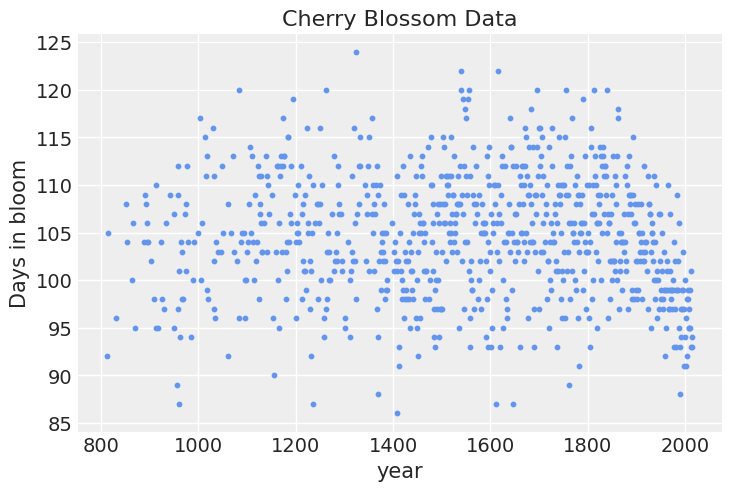

In [330]:
blossom_data.plot.scatter(
    "year", "doy", color="cornflowerblue", s=10, title="Cherry Blossom Data", ylabel="Days in bloom"
);

In [331]:
num_knots = 15
knot_list = np.quantile(blossom_data.year, np.linspace(0, 1, num_knots))
knot_list

array([ 812., 1036., 1174., 1269., 1377., 1454., 1518., 1583., 1650.,
       1714., 1774., 1833., 1893., 1956., 2015.])

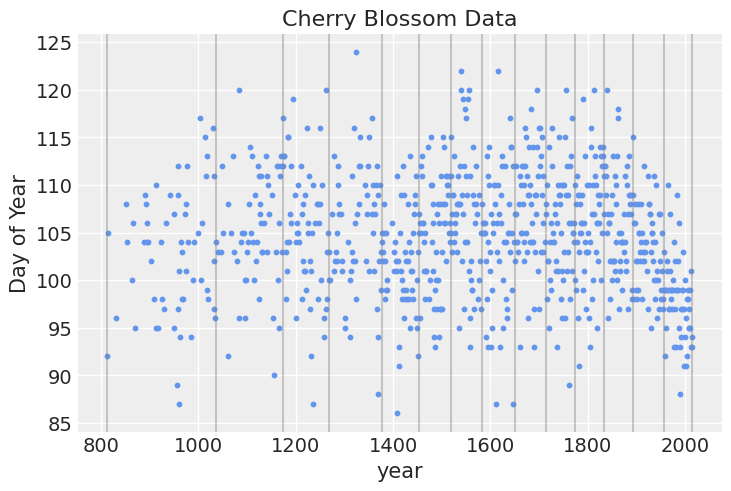

In [332]:
blossom_data.plot.scatter(
    "year", "doy", color="cornflowerblue", s=10, title="Cherry Blossom Data", ylabel="Day of Year"
)
for knot in knot_list:
    plt.gca().axvline(knot, color="grey", alpha=0.4);

In [334]:
B = dmatrix(
    "bs(year, knots=knots, degree=3, include_intercept=True) - 1",
    {"year": blossom_data.year.values, "knots": knot_list[1:-1]},
)
B

DesignMatrix with shape (827, 17)
  Columns:
    ['bs(year, knots=knots, degree=3, include_intercept=True)[0]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[1]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[2]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[3]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[4]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[5]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[6]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[7]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[8]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[9]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[10]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[11]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[12]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[13]',
     'bs(year

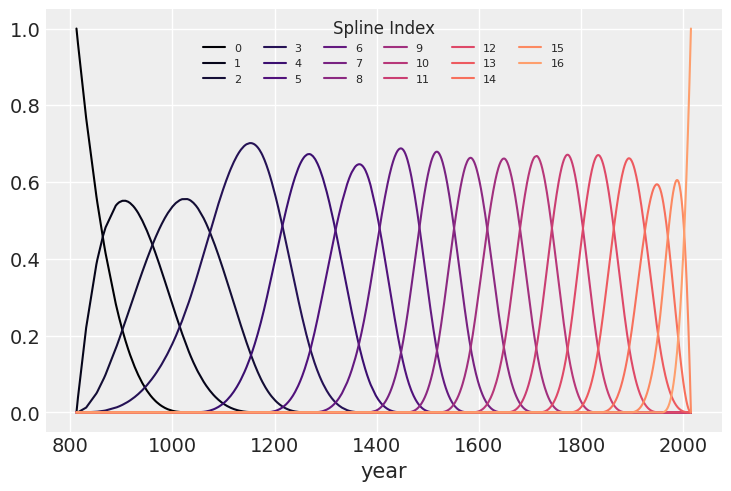

In [335]:
spline_df = (
    pd.DataFrame(B)
    .assign(year=blossom_data.year.values)
    .melt("year", var_name="spline_i", value_name="value")
)

color = plt.cm.magma(np.linspace(0, 0.80, len(spline_df.spline_i.unique())))

fig = plt.figure()
for i, c in enumerate(color):
    subset = spline_df.query(f"spline_i == {i}")
    subset.plot("year", "value", c=c, ax=plt.gca(), label=i)
plt.legend(title="Spline Index", loc="upper center", fontsize=8, ncol=6);

In [338]:
len(blossom_data.year)

827

In [340]:
blossom_data.year.nunique()

827